# スパイク処理付きGAT実装

元論文：Graph Attention Networks
Petar Veličković, Guillem Cucurull, Arantxa Casanova, Adriana Romero, Pietro Liò, Yoshua Bengio
ICLR 2018

https://arxiv.org/abs/1609.02907
参考にしたコード：https://github.com/Diego999/pyGAT

全体の流れ

0.   事前にcora.contentとcora.citesをダウンロードして/content/drive/My Drive/Colab Notebooks/に置いてください．
1.   ライブラリのインストール
2.   汎用関数の定義
3.   スパイク処理付きGATモデル定義（ベクトルノルムによる発火判定）
4.   グラフデータ読み込み
5.   学習準備
6.   モデル学習
7.   テスト精度検証
8.   結果の描画とスパイク統計


# ライブラリのインストール

In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import numpy as np
import scipy.sparse as sparse
import random as random
import os
import sys

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 汎用関数の定義

In [120]:
#乱数の固定化

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if "torch" in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

In [121]:
def load_data():
    print("Loading Cora dataset...")
    raw_nodes_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.content', dtype="str")
    print(raw_nodes_data)
    raw_node_ids = raw_nodes_data[:, 0].astype('int32')  # 各行の一列目に格納されてるノードIDを抽出
    #print(raw_node_ids)
    raw_node_labels = raw_nodes_data[:, -1]# 各行の最終列に格納されてるラベルを抽出．このラベルが予測ターゲット
    #print(raw_node_labels)

    unique = list(set(raw_node_labels))
    #print(unique)
    labels_enumerated = np.array([unique.index(label) for label in raw_node_labels])
    #print(labels_enumerated)
    node_features = sparse.csr_matrix(raw_nodes_data[:, 1:-1], dtype="float32")
    #print(node_features)

    ids_ordered = {raw_id: order for order, raw_id in enumerate(raw_node_ids)} #実際のノードIDを0から節点数-1に対応付け
    #print(ids_ordered)
    raw_edges_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.cites', dtype="int32")
    #print(raw_edges_data)
    edges = np.array(list(map(ids_ordered.get, raw_edges_data.flatten())), dtype='int32').reshape(raw_edges_data.shape) # 実際のノードIDを変換. reshapeでデータ構造を元の枝ファイルと同様に変更．
    #print(edges)

    adj = sparse.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels_enumerated.shape[0], labels_enumerated.shape[0]),
                            dtype=np.float32)
    #print(adj)

    adj = adj + adj.T.multiply(adj.T > adj) #隣接行列を対象に変更 (つまり，無向グラフに変換)
    #print(adj)

    adj = adj + sparse.eye(adj.shape[0]) #対角成分に1を挿入

    node_degrees = np.array(adj.sum(1)) #列毎の総和を計算する（つまり，次数を計算する）
    #print(node_degrees)

    node_degrees = np.power(node_degrees, -0.5).flatten()
    #print(node_degrees)

    degree_matrix = sparse.diags(node_degrees, dtype=np.float32)
    print(degree_matrix)

    adj = degree_matrix @ adj @ degree_matrix #行列の積を計算．
    #torch.spmm(degree_matrix,torch.spmm(adj,degree_matrix))

    print(adj)

    features = torch.FloatTensor(node_features.toarray())
    labels = torch.LongTensor(labels_enumerated)
    adj = torch.FloatTensor(np.array(adj.todense()))

    return features, labels, adj, edges

In [122]:
def visualize_embedding_tSNE(labels, y_pred, num_classes):

    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    node_labels = labels.cpu().numpy()
    out_features = y_pred.detach().cpu().numpy()
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0],
                    t_sne_embeddings[node_labels == class_id, 1], s=20,
                    color=cora_label_to_color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("Visualizing t-SNE for Spike GAT")
    plt.show()

def visualize_spike_statistics(spike_rates, spike_norms, threshold):
    """スパイク統計の可視化"""
    plt.figure(figsize=(15, 5))

    # スパイク率の時系列変化
    plt.subplot(1, 3, 1)
    plt.plot(spike_rates, linewidth=2, color='blue', marker='o', markersize=4)
    plt.xlabel('Training Step')
    plt.ylabel('Spike Rate')
    plt.title('Spike Rate Evolution')
    plt.grid(True, alpha=0.3)

    # 出力ノルムの分布
    plt.subplot(1, 3, 2)
    plt.hist(spike_norms, bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={threshold:.3f}')
    plt.xlabel('Output Norm')
    plt.ylabel('Number of Nodes')
    plt.title('Distribution of Output Norms')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # スパイクしている／していないノードの比率
    plt.subplot(1, 3, 3)
    firing_nodes = np.sum(spike_norms >= threshold)
    silent_nodes = len(spike_norms) - firing_nodes

    labels = ['Firing Nodes', 'Silent Nodes']
    sizes = [firing_nodes, silent_nodes]
    colors = ['lightcoral', 'lightblue']
    explode = (0.05, 0)  # 発火ノードを少し分離

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.title(f'Node Activity Distribution\n(Threshold={threshold:.3f})')

    plt.tight_layout()
    plt.show()

    # 統計情報の表示
    print(f"Threshold: {threshold:.3f}")
    print(f"Firing nodes: {firing_nodes}/{len(spike_norms)} ({firing_nodes/len(spike_norms)*100:.1f}%)")
    print(f"Average spike rate: {np.mean(spike_rates):.3f}")
    print(f"Final spike rate: {spike_rates[-1] if spike_rates else 0:.3f}")
    print(f"Norm statistics: mean={np.mean(spike_norms):.3f}, std={np.std(spike_norms):.3f}")
    print("-" * 50)

def visualize_membrane_potential_evolution(membrane_history, threshold, sample_nodes=10):
    """膜電位の蓄積過程を可視化"""
    if not membrane_history:
        print("No membrane potential history available.")
        return

    # 膜電位履歴をテンソルに変換
    history_tensor = torch.stack(membrane_history)  # (time_steps, num_nodes)
    num_time_steps, num_nodes = history_tensor.shape

    # サンプルノードを選択（ランダムに選ぶ）
    if num_nodes > sample_nodes:
        selected_nodes = np.random.choice(num_nodes, sample_nodes, replace=False)
    else:
        selected_nodes = range(num_nodes)

    plt.figure(figsize=(15, 10))

    # 個別ノードの膜電位推移
    plt.subplot(2, 2, 1)
    for i, node_idx in enumerate(selected_nodes):
        plt.plot(history_tensor[:, node_idx].numpy(),
                label=f'Node {node_idx}', alpha=0.7, linewidth=2)
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={threshold}')
    plt.xlabel('Forward Pass')
    plt.ylabel('Membrane Potential')
    plt.title(f'Membrane Potential Evolution (Sample {len(selected_nodes)} nodes)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # 全ノードの平均膜電位
    plt.subplot(2, 2, 2)
    mean_potential = history_tensor.mean(dim=1).numpy()
    std_potential = history_tensor.std(dim=1).numpy()
    time_steps = range(len(mean_potential))

    plt.plot(time_steps, mean_potential, 'b-', linewidth=2, label='Mean')
    plt.fill_between(time_steps, mean_potential - std_potential, mean_potential + std_potential,
                     alpha=0.3, color='blue', label='±1 std')
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={threshold}')
    plt.xlabel('Forward Pass')
    plt.ylabel('Membrane Potential')
    plt.title('Average Membrane Potential Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 膜電位の分布変化（ヒートマップ）
    plt.subplot(2, 2, 3)
    # 時間軸をサンプリング（表示用）
    sample_times = np.linspace(0, num_time_steps-1, min(50, num_time_steps), dtype=int)
    sample_history = history_tensor[sample_times, :sample_nodes].numpy()

    im = plt.imshow(sample_history.T, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(im, label='Membrane Potential')
    plt.xlabel('Forward Pass (sampled)')
    plt.ylabel('Node Index (sampled)')
    plt.title('Membrane Potential Heatmap')

    # 閾値超過ノード数の推移
    plt.subplot(2, 2, 4)
    threshold_exceeded = (history_tensor >= threshold).sum(dim=1).numpy()
    plt.plot(threshold_exceeded, 'g-', linewidth=2, marker='o', markersize=4)
    plt.xlabel('Forward Pass')
    plt.ylabel('Number of Nodes Above Threshold')
    plt.title('Nodes Ready to Spike')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 統計情報
    print(f"=== Membrane Potential Evolution Statistics ===")
    print(f"Time steps recorded: {num_time_steps}")
    print(f"Total nodes: {num_nodes}")
    print(f"Threshold: {threshold}")
    print(f"Final average membrane potential: {mean_potential[-1]:.3f}")
    print(f"Max membrane potential reached: {history_tensor.max().item():.3f}")
    print(f"Average nodes above threshold: {threshold_exceeded.mean():.1f}")
    print("-" * 50)

# スパイク処理付きGATモデル定義

In [123]:
class SpikeGraphAttentionLayer(nn.Module):
    """
    スパイク処理機能付きGraphAttentionLayer
    出力ベクトルのL2ノルムがしきい値を超えたノードのみが「発火」し、
    隣接ノードに信号を伝播する
    """
    def __init__(self, in_features, out_features, dropout, alpha, spike_threshold=1.0, final=False):
        super(SpikeGraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.final = final

        # スパイク関連パラメータ（fixedモードのみ）
        self.spike_threshold = spike_threshold

        # 膜電位（Integrate-and-Fireモデル用）
        self.membrane_potential = None  # 初回forward時に初期化

        # 統計情報保存用
        self.spike_counts = []
        self.output_norms = []

        # 膜電位の履歴保存用（蓄積の様子を確認するため）
        self.membrane_history = []  # 各forward時の膜電位を保存

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj, train_mask=None):
        Wh = torch.mm(h, self.W)
        e = self._prepare_attentional_mechanism_input(Wh)

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh)

        # 活性化関数を適用（最終層以外）
        if not self.final:
            h_prime = F.elu(h_prime)

        # スパイク処理: L2ノルムによる発火判定
        h_prime_with_spike = self._apply_spike_mechanism(h_prime, train_mask)

        return h_prime_with_spike

    def _apply_spike_mechanism(self, h_prime, train_mask=None):
        """
        Integrate-and-Fireモデルに基づくスパイク機構を適用
        膜電位にノルムを蓄積し、閾値を超えたらスパイク＆リセット
        """
        num_nodes = h_prime.size(0)
        device = h_prime.device

        # 膜電位の初期化（初回のみ）
        if self.membrane_potential is None:
            self.membrane_potential = torch.zeros(num_nodes, device=device)

        # デバイスが変わった場合の対応
        if self.membrane_potential.device != device:
            self.membrane_potential = self.membrane_potential.to(device)

        # 各ノードの出力ベクトルのL2ノルムを計算
        output_norms = torch.norm(h_prime, p=2, dim=1)

        # 膜電位にノルムを蓄積（Integrate）
        self.membrane_potential += output_norms

        # スパイク判定：膜電位が閾値を超えたノード
        spike_mask = (self.membrane_potential >= self.spike_threshold).float()

        # スパイクしたノードの膜電位をリセット（Fire & Reset）
        self.membrane_potential[spike_mask.bool()] = 0.0

        # デバッグ出力（最初の数回のみ表示）
        debug_counter = getattr(self, '_debug_counter', 0)
        if debug_counter < 10:
            print(f"[SpikeDebug] Layer: {self.__class__.__name__}, training={self.training}")
            print(f"[SpikeDebug] threshold={self.spike_threshold:.4f}")
            print(f"[SpikeDebug] output_norms.min={output_norms.min().item():.4f}, "
                  f"output_norms.max={output_norms.max().item():.4f}")
            print(f"[SpikeDebug] membrane_potential.min={self.membrane_potential.min().item():.4f}, "
                  f"membrane_potential.max={self.membrane_potential.max().item():.4f}")
            print(f"[SpikeDebug] spike_mask.sum={spike_mask.sum().item():.0f} "
                  f"({spike_mask.sum().item()/num_nodes*100:.1f}%)")
            print("-" * 50)
            self._debug_counter = debug_counter + 1

        # スパイクマスクを適用（発火していないノードの出力を0にする）
        spike_mask_expanded = spike_mask.unsqueeze(1)  # (num_nodes, 1)
        h_prime_spiked = h_prime * spike_mask_expanded

        # 統計情報の保存（学習時のみ、訓練ノードのみ）
        if self.training:
            if train_mask is not None:
                # 訓練ノードのみの統計を保存
                train_output_norms = output_norms[train_mask]
                train_spike_mask = spike_mask[train_mask]
                self.output_norms.append(train_output_norms.detach().cpu())
                self.spike_counts.append(train_spike_mask.sum().item())
            else:
                # train_maskが提供されない場合は全ノード（後方互換性）
                self.output_norms.append(output_norms.detach().cpu())
                self.spike_counts.append(spike_mask.sum().item())

        # 膜電位の履歴を保存（蓄積の様子を確認するため）
        if len(self.membrane_history) < 100:  # 最初の100回のみ保存（メモリ節約）
            self.membrane_history.append(self.membrane_potential.detach().cpu().clone())

        return h_prime_spiked

    def _prepare_attentional_mechanism_input(self, Wh):
        Wh1 = torch.matmul(Wh, self.a[:self.out_features, :])
        Wh2 = torch.matmul(Wh, self.a[self.out_features:, :])
        e = Wh1 + Wh2.T
        return self.leakyrelu(e)

    def get_spike_statistics(self):
        """スパイク統計情報を取得"""
        if len(self.spike_counts) == 0:
            return None, None, 0

        all_norms = torch.cat(self.output_norms, dim=0)
        # spike_rateの計算：各エポックでの訓練ノード数で正規化
        total_train_nodes = len(all_norms) // len(self.spike_counts) if len(self.spike_counts) > 0 else 1
        spike_rates = [count / total_train_nodes for count in self.spike_counts]

        # 固定しきい値を返す
        threshold = self.spike_threshold

        return spike_rates, all_norms.numpy(), threshold

    def reset_spike_statistics(self):
        """スパイク統計情報をリセット"""
        self.spike_counts = []
        self.output_norms = []
        self.membrane_history = []

    def reset_membrane_potential(self):
        """膜電位をリセット（Integrate-and-Fireモデル用）"""
        if self.membrane_potential is not None:
            self.membrane_potential.zero_()

    def reset_state(self):
        """膜電位と統計情報をすべてリセット"""
        self.reset_membrane_potential()
        self.reset_spike_statistics()

    def __repr__(self):
        return self.__class__.__name__ + f' ({self.in_features} -> {self.out_features}, threshold={self.spike_threshold})'


In [124]:
class SpikeGAT(nn.Module):
    """
    スパイク処理機能付きGraph Attention Network
    各層でスパイク判定を行い、発火したノードのみが信号を伝播
    """
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads, spike_threshold=1.0):
        super(SpikeGAT, self).__init__()
        self.dropout = dropout
        self.spike_threshold = spike_threshold

        # マルチヘッドアテンション層（スパイク機能付き）
        self.attentions = []
        for i in range(nheads):
            self.attentions.append(
                SpikeGraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha,
                                       spike_threshold=spike_threshold, final=False)
            )
            self.add_module('attention_{}'.format(i), self.attentions[i])

        # 出力層（スパイク機能付き）
        self.out_att = SpikeGraphAttentionLayer(nhid * nheads, nclass, dropout=dropout,
                                              alpha=alpha, spike_threshold=spike_threshold, final=True)

    def forward(self, x, adj, train_mask=None):
        # 入力層のドロップアウト
        x = F.dropout(x, self.dropout, training=self.training)

        # マルチヘッドアテンション（各ヘッドでスパイク処理）
        x = torch.cat([att(x, adj, train_mask) for att in self.attentions], dim=1)

        # 中間層のドロップアウト
        x = F.dropout(x, self.dropout, training=self.training)

        # 出力層（スパイク処理付き）
        x = self.out_att(x, adj, train_mask)

        # 元のGATと同じ出力形式に修正（CrossEntropyLoss用）
        return x  # CrossEntropyLossは内部でlog_softmaxを適用するため、生の出力を返す

    def get_all_spike_statistics(self):
        """全層のスパイク統計情報を取得"""
        stats = {}

        # 各アテンションヘッドの統計
        for i, att in enumerate(self.attentions):
            spike_rates, norms, threshold = att.get_spike_statistics()
            if spike_rates is not None:
                stats[f'head_{i}'] = {
                    'spike_rates': spike_rates,
                    'norms': norms,
                    'threshold': threshold
                }

        # 出力層の統計
        spike_rates, norms, threshold = self.out_att.get_spike_statistics()
        if spike_rates is not None:
            stats['output'] = {
                'spike_rates': spike_rates,
                'norms': norms,
                'threshold': threshold
            }

        return stats

    def reset_all_spike_statistics(self):
        """全層のスパイク統計情報をリセット"""
        for att in self.attentions:
            att.reset_spike_statistics()
        self.out_att.reset_spike_statistics()

    def reset_all_membrane_potential(self):
        """全層の膜電位をリセット"""
        for att in self.attentions:
            att.reset_membrane_potential()
        self.out_att.reset_membrane_potential()

    def reset_all_state(self):
        """全層の膜電位と統計情報をすべてリセット"""
        for att in self.attentions:
            att.reset_state()
        self.out_att.reset_state()

    def get_average_spike_rate(self):
        """平均スパイク率を計算"""
        stats = self.get_all_spike_statistics()
        all_rates = []

        for layer_stats in stats.values():
            all_rates.extend(layer_stats['spike_rates'])

        if len(all_rates) > 0:
            return np.mean(all_rates)
        return 0.0

# グラフデータ読み込み

グラフ読み込み

In [125]:
features, labels, adj, edges = load_data()

Loading Cora dataset...
[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']]
<DIAgonal sparse matrix of dtype 'float32'
	with 2708 stored elements (1 diagonals) and shape (2708, 2708)>
  Coords	Values
  (0, 0)	0.40824830532073975
  (1, 1)	0.7071067690849304
  (2, 2)	0.4472135901451111
  (3, 3)	0.5
  (4, 4)	0.7071067690849304
  (5, 5)	0.5773502588272095
  (6, 6)	0.5773502588272095
  (7, 7)	0.7071067690849304
  (8, 8)	0.40824830532073975
  (9, 9)	0.4472135901451111
  (10, 10)	0.40824830532073975
  (11, 11)	0.5773502588272095
  (12, 12)	0.5773502588272095
  (13, 13)	0.5
  (14, 14)	0.22360679507255554
  (15, 15)	0.30151134729385376
  (16, 16)	0.4472135901451111
  (17, 17)	0.7071067690849304
  (18, 18)	0.3535533845424652
  (19, 19)	0.5773

In [126]:
print(features)
print(labels)
print(adj)
print(edges)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([4, 2, 0,  ..., 3, 5, 4])
tensor([[0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500]])
[[ 163  402]
 [ 163  659]
 [ 163 1696]
 ...
 [1887 2258]
 [1902 1887]
 [ 837 1686]]


# 学習準備

In [127]:
num_classes = int(labels.max().item() + 1)
train_size_per_class=20
validation_size=500
test_size=1000
classes = [ind for ind in range(num_classes)]
train_set = []

# Construct train set (indices) out of 20 samples per each class
for class_label in classes:
    target_indices = torch.nonzero(labels == class_label, as_tuple=False).tolist()
    train_set += [ind[0] for ind in target_indices[:train_size_per_class]]

# Extract the remaining samples
validation_test_set = [ind for ind in range(len(labels)) if ind not in train_set]
# Split the remaining samples into validation/test set
validation_set = validation_test_set[:validation_size]
test_set = validation_test_set[validation_size:validation_size+test_size]

In [128]:
# スパイクGATのパラメータ設定
dropout = 0.2
hidden_dim = 32
nb_heads = 4
alpha = 0.2

# スパイク関連パラメータ（Integrate-and-Fireモデル）
spike_threshold = 1.0        # 膜電位の閾値（蓄積型なので0より大きい値に設定）

model = SpikeGAT(nfeat=features.shape[1],
                 nhid=hidden_dim,
                 nclass=num_classes,
                 dropout=dropout,
                 nheads=nb_heads,
                 alpha=alpha,
                 spike_threshold=spike_threshold)

# デバッグ出力（追加）
print(">>> SpikeGAT params:")
print(f"  spike_threshold={model.spike_threshold}")

# 各層のパラメータも確認
print(">>> Individual layer params:")
for i, att in enumerate(model.attentions):
    print(f"  attention_{i}: thresh={att.spike_threshold}")
print(f"  out_att: thresh={model.out_att.spike_threshold}")

print("=== Spike GAT Model ===")
print(model)
print(f"\nSpike Parameters:")
print(f"- Spike threshold: {spike_threshold}")

>>> SpikeGAT params:
  spike_threshold=1.0
>>> Individual layer params:
  attention_0: thresh=1.0
  attention_1: thresh=1.0
  attention_2: thresh=1.0
  attention_3: thresh=1.0
  out_att: thresh=1.0
=== Spike GAT Model ===
SpikeGAT(
  (attention_0): SpikeGraphAttentionLayer (1433 -> 32, threshold=1.0)
  (attention_1): SpikeGraphAttentionLayer (1433 -> 32, threshold=1.0)
  (attention_2): SpikeGraphAttentionLayer (1433 -> 32, threshold=1.0)
  (attention_3): SpikeGraphAttentionLayer (1433 -> 32, threshold=1.0)
  (out_att): SpikeGraphAttentionLayer (128 -> 7, threshold=1.0)
)

Spike Parameters:
- Spike threshold: 1.0


In [129]:
if torch.cuda.is_available():
    model.cuda()
    adj = adj.cuda()
    features = features.cuda()
    labels = labels.cuda()
    print("Using GPU for training")
else:
    print("Using CPU for training")

# スパイク統計と膜電位をリセット
model.reset_all_state()

# 元のGATと同じパラメータに修正
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()  # 元のGATと同じ損失関数を使用


Using GPU for training


In [130]:
def accuracy(output, labels):
    y_pred = output.max(1)[1].type_as(labels)
    correct = y_pred.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# モデル学習

In [131]:
print("=== Training Spike GAT (Integrate-and-Fire) ===")
print(f"[TrainDebug] train_set size: {len(train_set)}")
print(f"[TrainDebug] validation_set size: {len(validation_set)}")
print(f"[TrainDebug] test_set size: {len(test_set)}")
print(f"[TrainDebug] total nodes: {len(labels)}")

# 膜電位リセットのオプション
reset_membrane_per_epoch = False  # Trueにするとエポック毎に膜電位をリセット
print(f"[TrainDebug] reset_membrane_per_epoch: {reset_membrane_per_epoch}")

validation_acc = []
validation_loss = []
training_acc = []
training_loss = []

# Early stopping設定（元のGATと同じ）
use_early_stopping = True
patience = 0.001  # 元のGATと同じ設定

if use_early_stopping:
    last_min_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False

# train_maskを作成
train_mask = torch.zeros(len(labels), dtype=torch.bool)
train_mask[train_set] = True
if torch.cuda.is_available():
    train_mask = train_mask.cuda()

t_start = time.time()
maxepoch = 1000
for epoch in range(maxepoch):
    # エポック開始時に膜電位をリセット（オプション）
    if reset_membrane_per_epoch:
        model.reset_all_membrane_potential()

    optimizer.zero_grad()
    model.train()

    # 訓練時はtrain_maskを渡す（データリークージ回避）
    y_pred = model(features, adj, train_mask)
    train_loss = criterion(y_pred[train_set], labels[train_set])
    train_acc = accuracy(y_pred[train_set], labels[train_set])
    train_loss.backward()
    optimizer.step()

    training_loss.append(train_loss.item())
    training_acc.append(train_acc)

    with torch.no_grad():
        model.eval()
        # 評価時はtrain_maskを渡さない（推論時は全ノードで計算）
        y_pred_val = model(features, adj)
        val_loss = criterion(y_pred_val[validation_set], labels[validation_set])
        val_acc = accuracy(y_pred_val[validation_set], labels[validation_set])

        validation_loss.append(val_loss.item())
        validation_acc.append(val_acc)

        if use_early_stopping:
            if val_loss < last_min_val_loss:
                last_min_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience:
                    stopped_early = True
                    t_end = time.time()

    # 元のGATと同じ出力フォーマット
    if epoch % 10 == 0:  # 10エポック毎に出力（元のGATと同じ）
        avg_spike_rate = model.get_average_spike_rate()
        print(" | ".join([f"Epoch: {epoch:4d}", f"Train loss: {train_loss.item():.3f}",
                        f"Train acc: {train_acc:.2f}",  # 小数点2桁（元のGATと同じ）
                        f"Val loss: {val_loss.item():.3f}",
                        f"Val acc: {val_acc:.2f}",      # 小数点2桁（元のGATと同じ）
                        f"Spike rate: {avg_spike_rate:.3f}"]))

    if use_early_stopping and stopped_early:
        break

if use_early_stopping and stopped_early:
    print(f"EARLY STOPPING condition met. Stopped at epoch: {epoch}.")
else:
    t_end = time.time()

print(f"Total training time: {t_end-t_start:.2f} seconds")

# 最終スパイク統計の表示
final_spike_rate = model.get_average_spike_rate()
print(f"Final average spike rate: {final_spike_rate:.3f}")

# 各層のスパイク統計
spike_stats = model.get_all_spike_statistics()
print(f"\nSpike Statistics by Layer:")
for layer_name, stats in spike_stats.items():
    avg_rate = np.mean(stats['spike_rates']) if stats['spike_rates'] else 0
    print(f"- {layer_name}: avg_rate={avg_rate:.3f}, threshold={stats['threshold']:.3f}")

=== Training Spike GAT (Integrate-and-Fire) ===
[TrainDebug] train_set size: 140
[TrainDebug] validation_set size: 500
[TrainDebug] test_set size: 1000
[TrainDebug] total nodes: 2708
[TrainDebug] reset_membrane_per_epoch: False
[SpikeDebug] Layer: SpikeGraphAttentionLayer, training=True
[SpikeDebug] threshold=1.0000
[SpikeDebug] output_norms.min=0.0000, output_norms.max=2.0160
[SpikeDebug] membrane_potential.min=0.0000, membrane_potential.max=1.0000
[SpikeDebug] spike_mask.sum=720 (26.6%)
--------------------------------------------------
[SpikeDebug] Layer: SpikeGraphAttentionLayer, training=True
[SpikeDebug] threshold=1.0000
[SpikeDebug] output_norms.min=0.0000, output_norms.max=1.9480
[SpikeDebug] membrane_potential.min=0.0000, membrane_potential.max=0.9990
[SpikeDebug] spike_mask.sum=698 (25.8%)
--------------------------------------------------
[SpikeDebug] Layer: SpikeGraphAttentionLayer, training=True
[SpikeDebug] threshold=1.0000
[SpikeDebug] output_norms.min=0.0000, output_nor

# テスト精度の検証

In [132]:
print("=== Test Results (Spike GAT) ===")
with torch.no_grad():
    model.eval()
    # テスト時はtrain_maskを渡さない（推論時は全ノードで計算）
    y_pred = model(features, adj)
    test_loss = criterion(y_pred[test_set], labels[test_set])
    test_acc = accuracy(y_pred[test_set], labels[test_set])

print(f"Test loss: {test_loss:.3f}  |  Test acc: {test_acc:.2f}")  # 元のGATと同じフォーマット

# テスト時のスパイク統計
test_spike_rate = model.get_average_spike_rate()
print(f"Test spike rate: {test_spike_rate:.3f}")

# 詳細なスパイク統計表示
test_spike_stats = model.get_all_spike_statistics()
print(f"\nDetailed Spike Statistics:")
for layer_name, stats in test_spike_stats.items():
    if stats['spike_rates']:
        avg_rate = np.mean(stats['spike_rates'])
        last_rate = stats['spike_rates'][-1] if stats['spike_rates'] else 0
        print(f"- {layer_name}: avg={avg_rate:.3f}, last={last_rate:.3f}, threshold={stats['threshold']:.3f}")

        # 発火率の分布
        firing_nodes = np.sum(stats['norms'] >= stats['threshold'])
        total_nodes = len(stats['norms'])
        print(f"  └─ Firing nodes: {firing_nodes}/{total_nodes} ({firing_nodes/total_nodes:.3f})")

=== Test Results (Spike GAT) ===
Test loss: 0.740  |  Test acc: 0.77
Test spike rate: 0.836

Detailed Spike Statistics:
- head_0: avg=0.819, last=0.836, threshold=1.000
  └─ Firing nodes: 92733/140000 (0.662)
- head_1: avg=0.828, last=0.829, threshold=1.000
  └─ Firing nodes: 89385/140000 (0.638)
- head_2: avg=0.813, last=0.871, threshold=1.000
  └─ Firing nodes: 92793/140000 (0.663)
- head_3: avg=0.827, last=0.907, threshold=1.000
  └─ Firing nodes: 91203/140000 (0.651)
- output: avg=0.893, last=0.986, threshold=1.000
  └─ Firing nodes: 117605/140000 (0.840)


# 結果の描画とスパイク統計

まずは，訓練データのロスと精度，開発データのロスと精度がエポック毎にどのように変化してるか見てみましょう．

=== Plotting Results ===


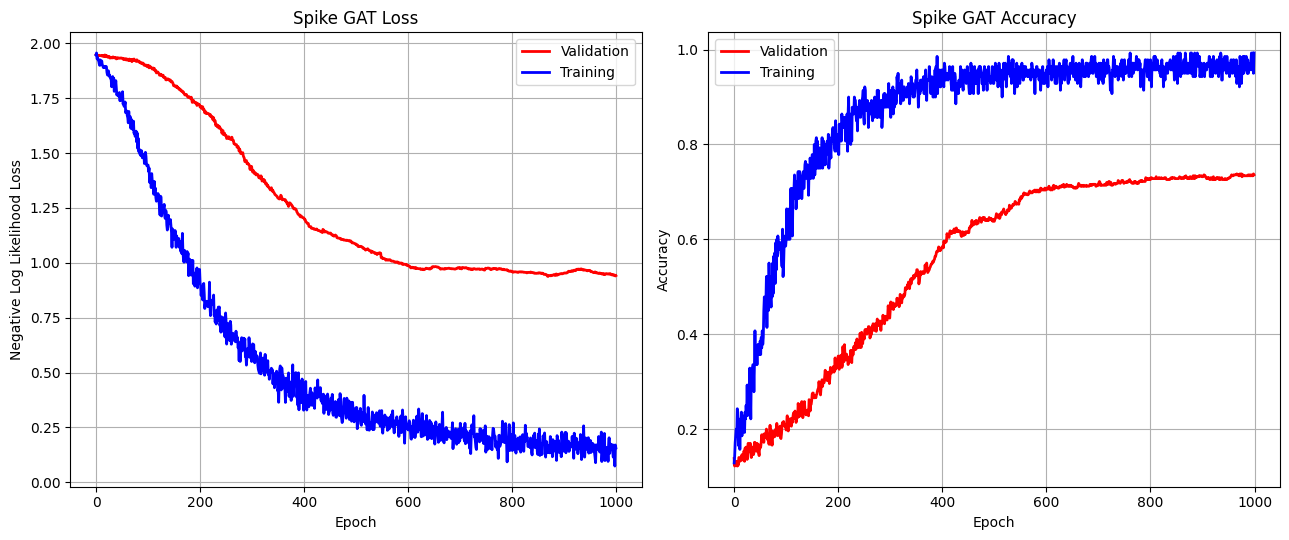

In [133]:
print("=== Plotting Results ===")
f, axs = plt.subplots(1, 2, figsize=(13, 5.5))
axs[0].plot(validation_loss, linewidth=2, color="red", label="Validation")
axs[0].plot(training_loss, linewidth=2, color="blue", label="Training")
axs[0].set_title("Spike GAT Loss")
axs[0].set_ylabel("Negative Log Likelihood Loss")
axs[0].set_xlabel("Epoch")
axs[0].legend()
axs[0].grid()

# GPU tensorsをCPUに移してからplotting
validation_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in validation_acc]
training_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in training_acc]

axs[1].plot(validation_acc_cpu, linewidth=2, color="red", label="Validation")
axs[1].plot(training_acc_cpu, linewidth=2, color="blue", label="Training")
axs[1].set_title("Spike GAT Accuracy")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

学習後のSpike GAT特徴表現がラベルごとにかたまっているか見てみましょう．
ここでは，tSNEを用いて多次元データを2次元に落とし込んで可視化をします．

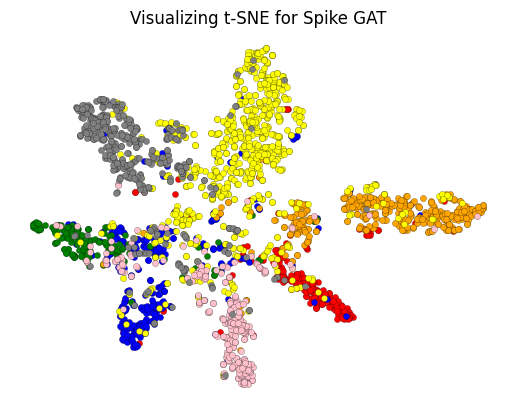

In [134]:
visualize_embedding_tSNE(labels, y_pred, num_classes)

=== Detailed Spike Analysis ===

HEAD_0 Layer Analysis:
- Average spike rate: 0.819
- Spike rate std: 0.056
- Threshold: 1.000
- Norm mean: 1.387
- Norm std: 0.693
- Firing nodes: 92733/140000 (66.2%)


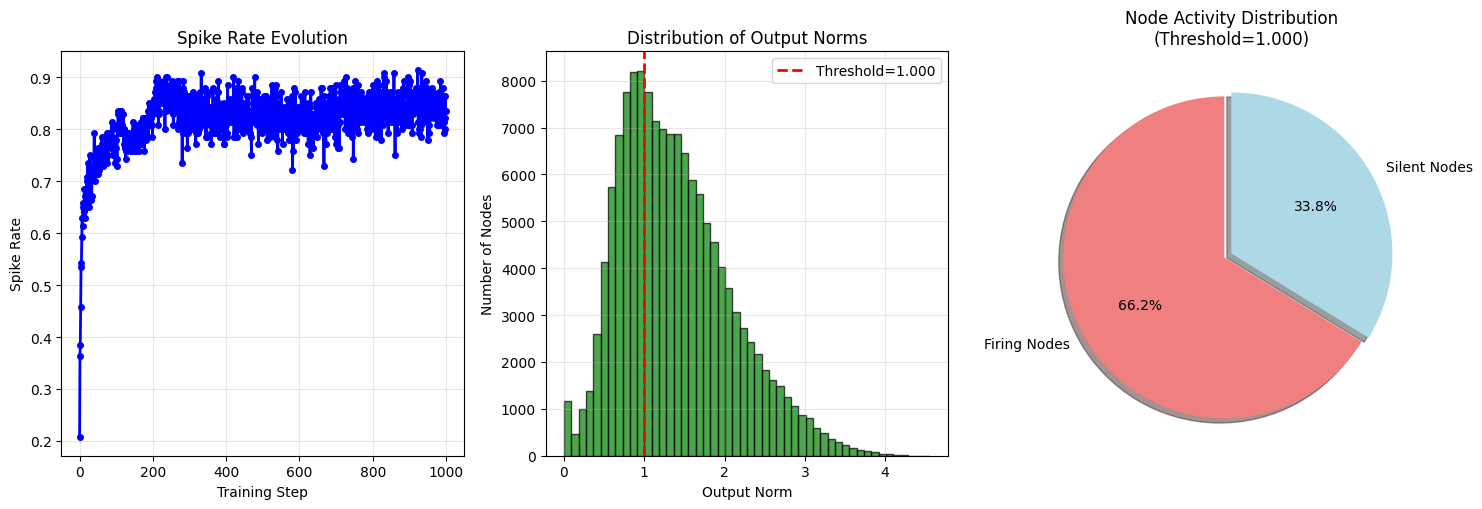

Threshold: 1.000
Firing nodes: 92733/140000 (66.2%)
Average spike rate: 0.819
Final spike rate: 0.836
Norm statistics: mean=1.387, std=0.693
--------------------------------------------------

HEAD_1 Layer Analysis:
- Average spike rate: 0.828
- Spike rate std: 0.068
- Threshold: 1.000
- Norm mean: 1.256
- Norm std: 0.539
- Firing nodes: 89385/140000 (63.8%)


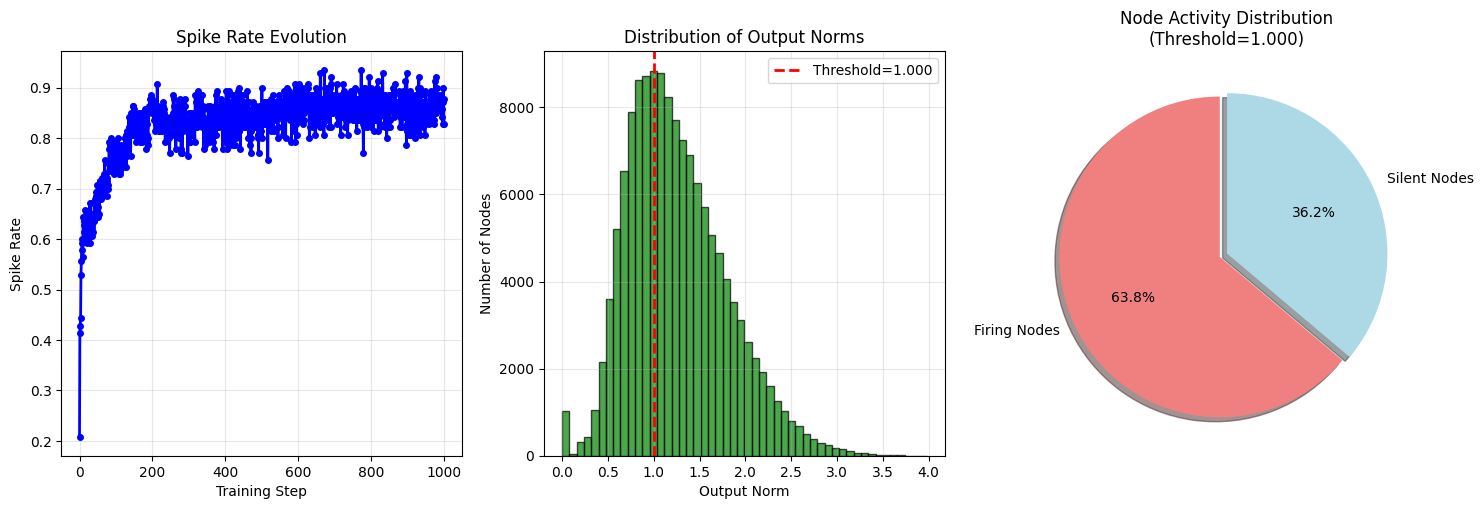

Threshold: 1.000
Firing nodes: 89385/140000 (63.8%)
Average spike rate: 0.828
Final spike rate: 0.829
Norm statistics: mean=1.256, std=0.539
--------------------------------------------------

HEAD_2 Layer Analysis:
- Average spike rate: 0.813
- Spike rate std: 0.051
- Threshold: 1.000
- Norm mean: 1.428
- Norm std: 0.766
- Firing nodes: 92793/140000 (66.3%)


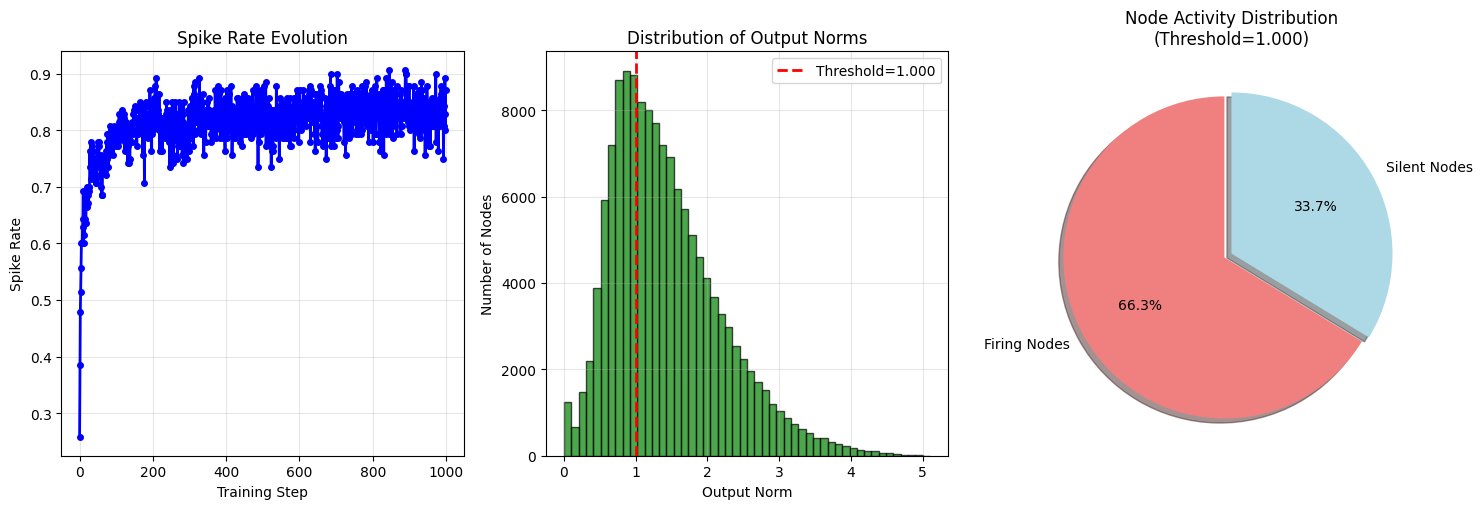

Threshold: 1.000
Firing nodes: 92793/140000 (66.3%)
Average spike rate: 0.813
Final spike rate: 0.871
Norm statistics: mean=1.428, std=0.766
--------------------------------------------------

HEAD_3 Layer Analysis:
- Average spike rate: 0.827
- Spike rate std: 0.055
- Threshold: 1.000
- Norm mean: 1.406
- Norm std: 0.875
- Firing nodes: 91203/140000 (65.1%)


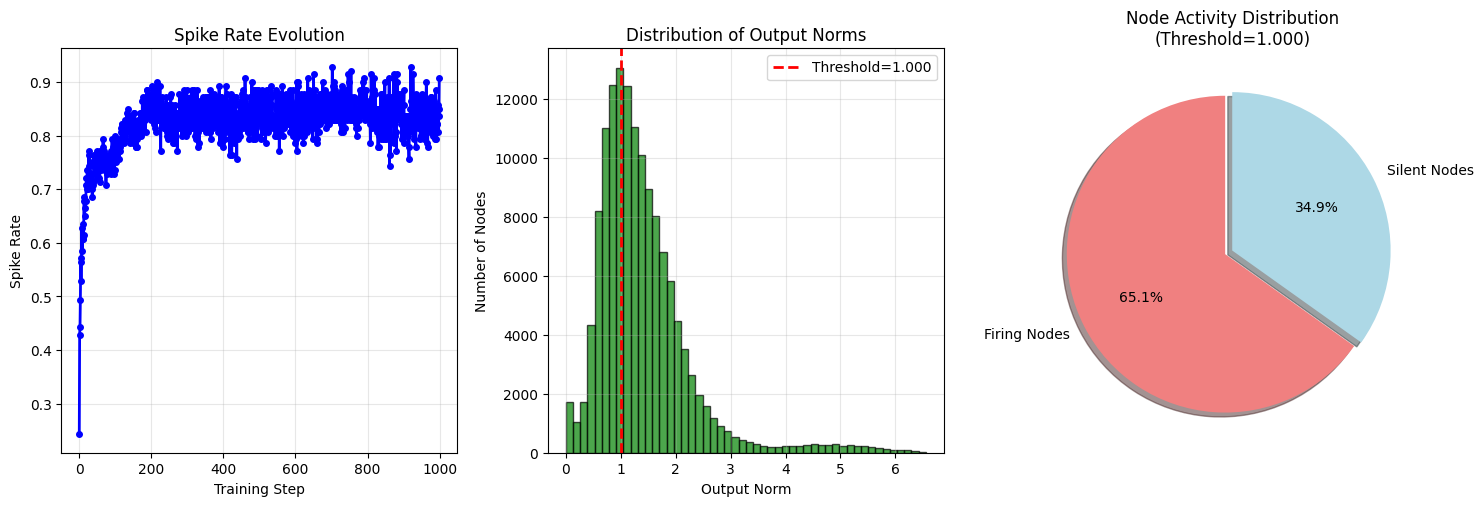

Threshold: 1.000
Firing nodes: 91203/140000 (65.1%)
Average spike rate: 0.827
Final spike rate: 0.907
Norm statistics: mean=1.406, std=0.875
--------------------------------------------------

OUTPUT Layer Analysis:
- Average spike rate: 0.893
- Spike rate std: 0.144
- Threshold: 1.000
- Norm mean: 4.074
- Norm std: 2.764
- Firing nodes: 117605/140000 (84.0%)


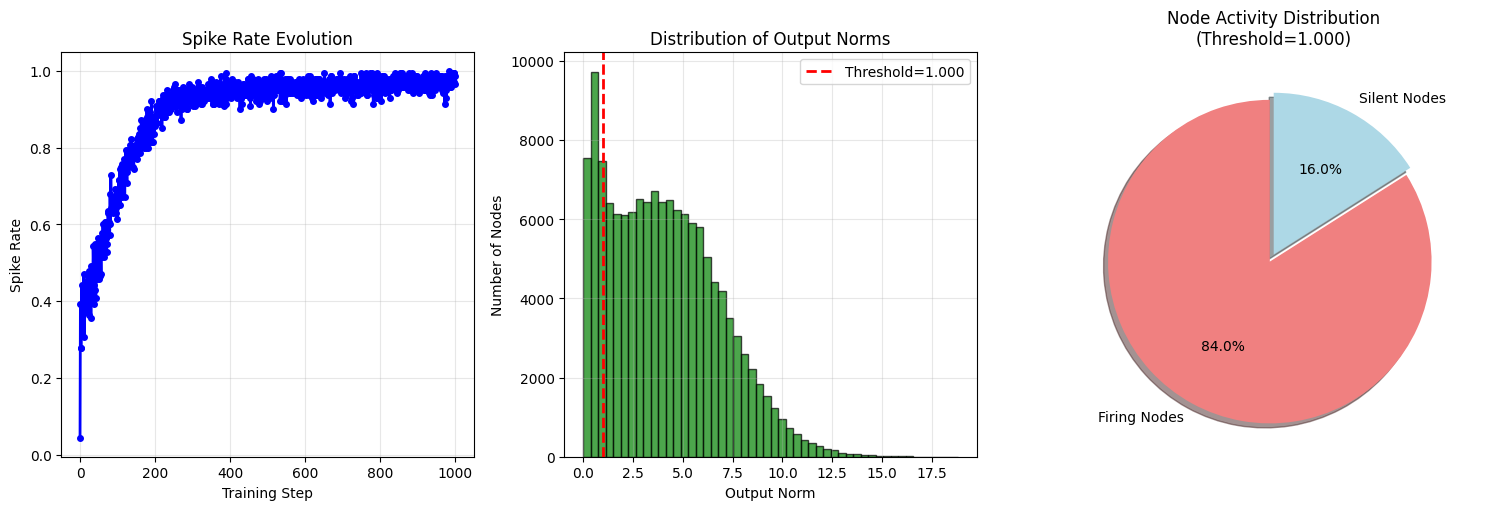

Threshold: 1.000
Firing nodes: 117605/140000 (84.0%)
Average spike rate: 0.893
Final spike rate: 0.986
Norm statistics: mean=4.074, std=2.764
--------------------------------------------------

=== Membrane Potential Evolution Analysis ===

HEAD_0 Layer Membrane Potential Evolution:


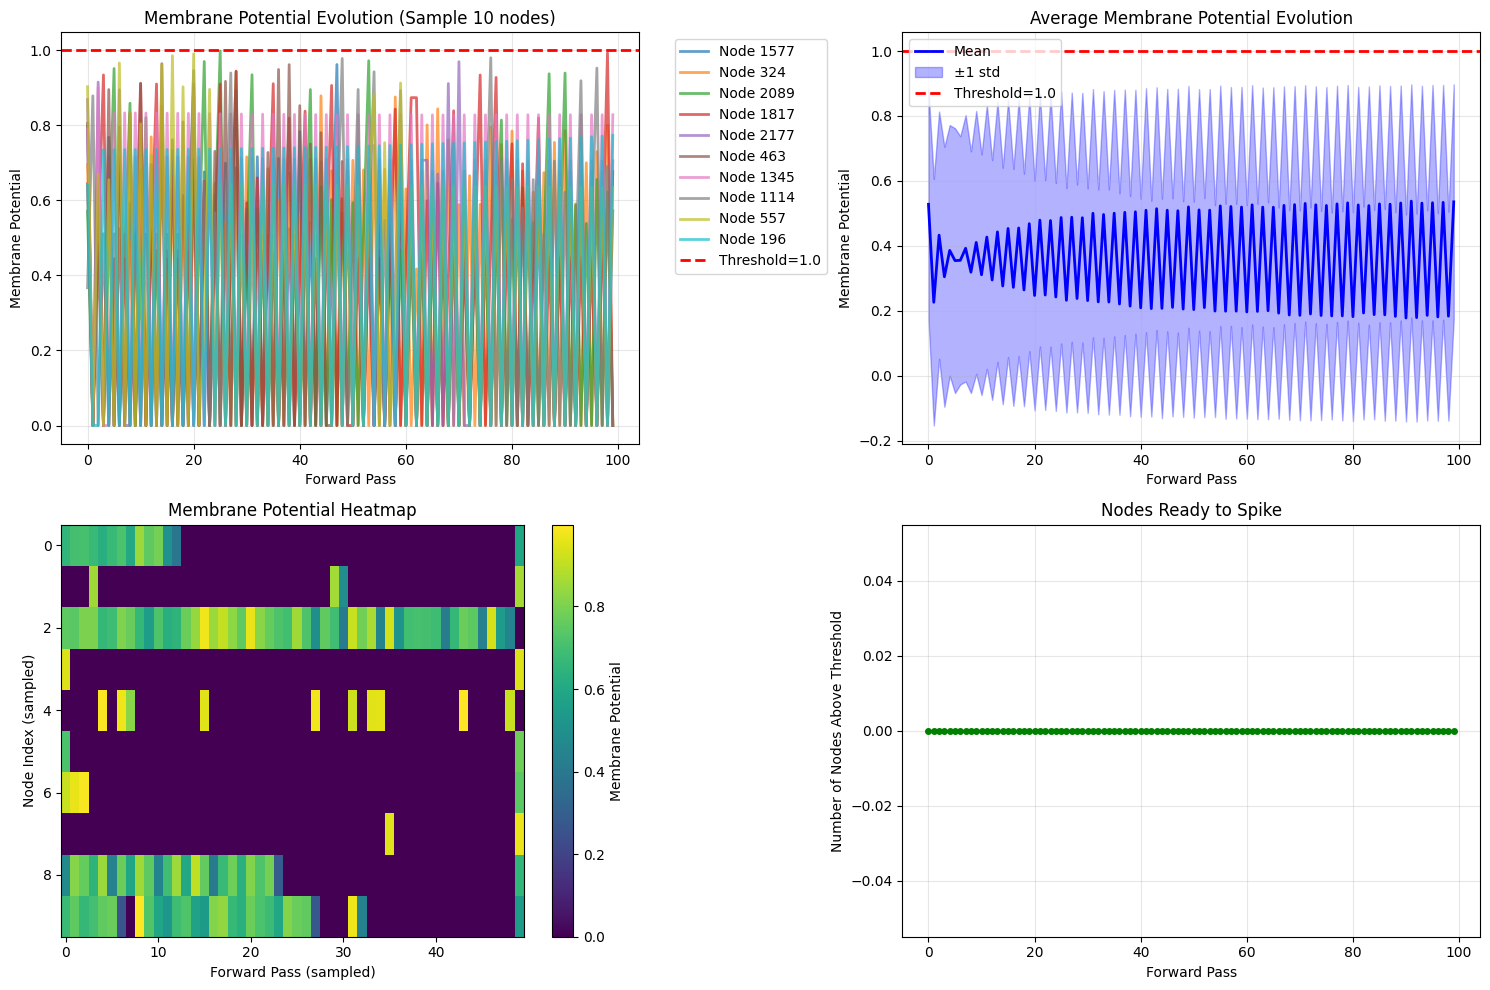

=== Membrane Potential Evolution Statistics ===
Time steps recorded: 100
Total nodes: 2708
Threshold: 1.0
Final average membrane potential: 0.535
Max membrane potential reached: 1.000
Average nodes above threshold: 0.0
--------------------------------------------------

HEAD_1 Layer Membrane Potential Evolution:


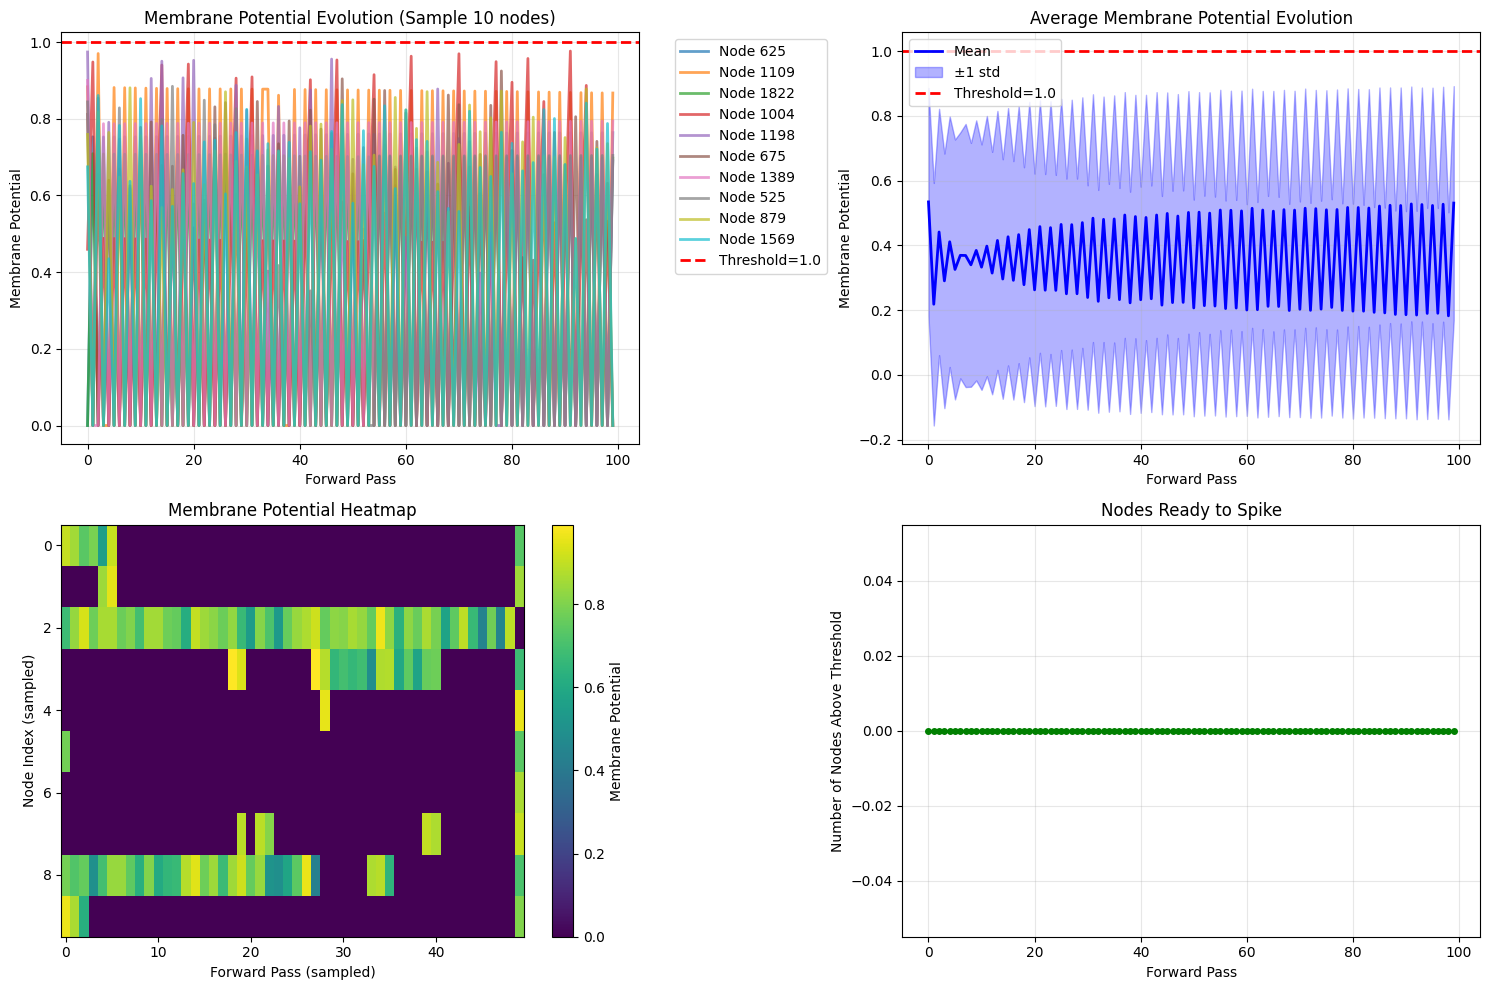

=== Membrane Potential Evolution Statistics ===
Time steps recorded: 100
Total nodes: 2708
Threshold: 1.0
Final average membrane potential: 0.530
Max membrane potential reached: 1.000
Average nodes above threshold: 0.0
--------------------------------------------------

HEAD_2 Layer Membrane Potential Evolution:


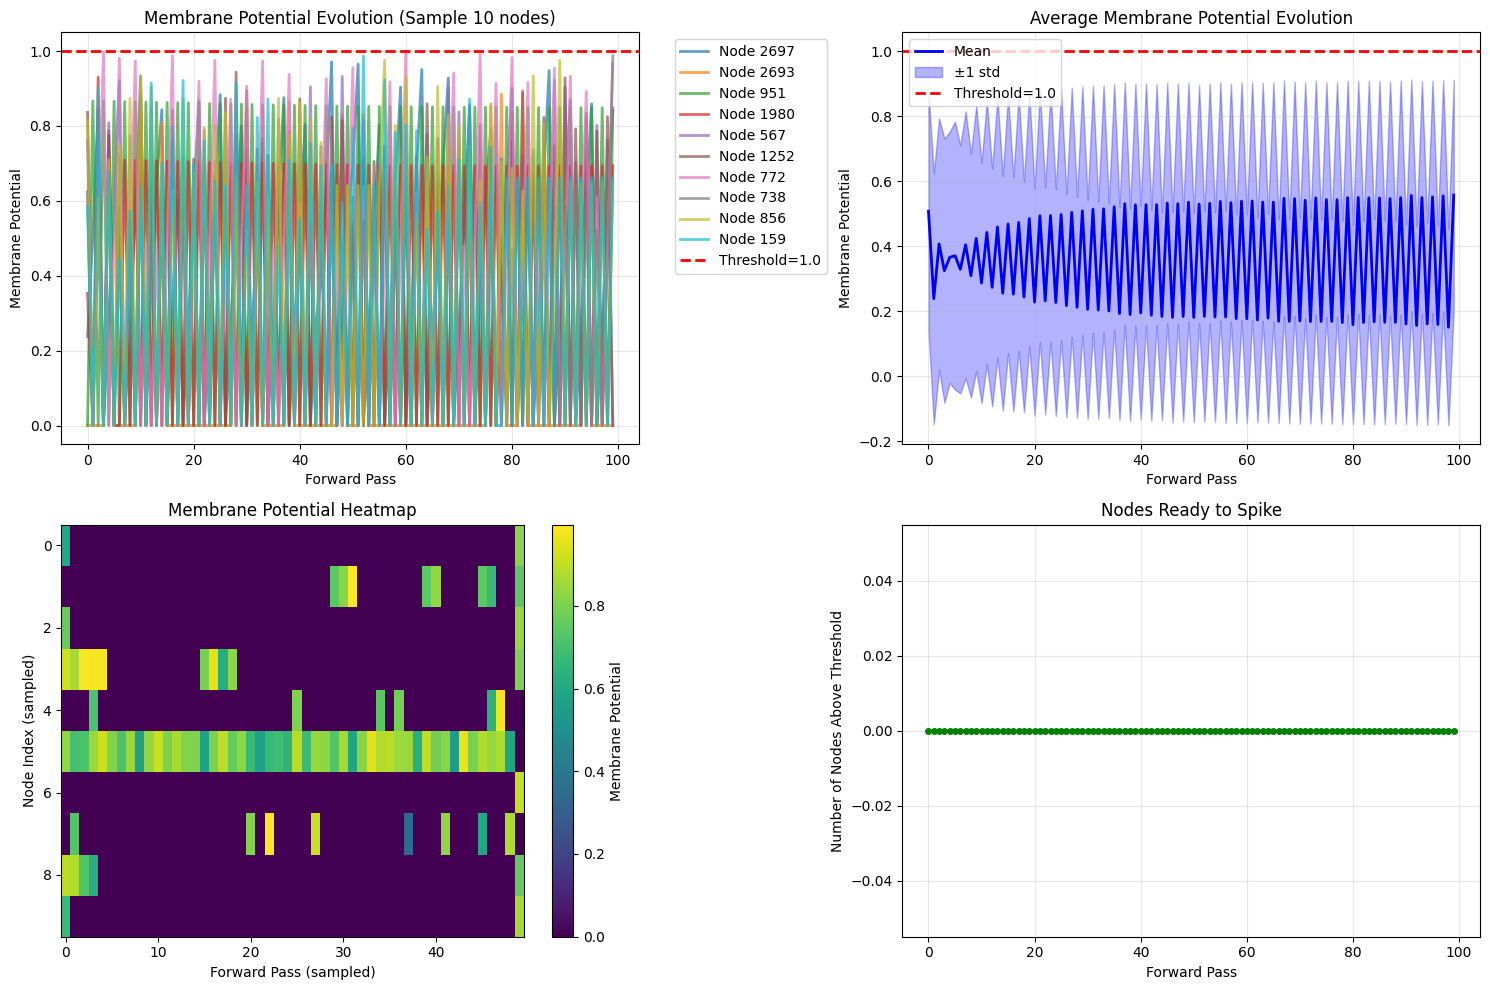

=== Membrane Potential Evolution Statistics ===
Time steps recorded: 100
Total nodes: 2708
Threshold: 1.0
Final average membrane potential: 0.557
Max membrane potential reached: 1.000
Average nodes above threshold: 0.0
--------------------------------------------------

HEAD_3 Layer Membrane Potential Evolution:


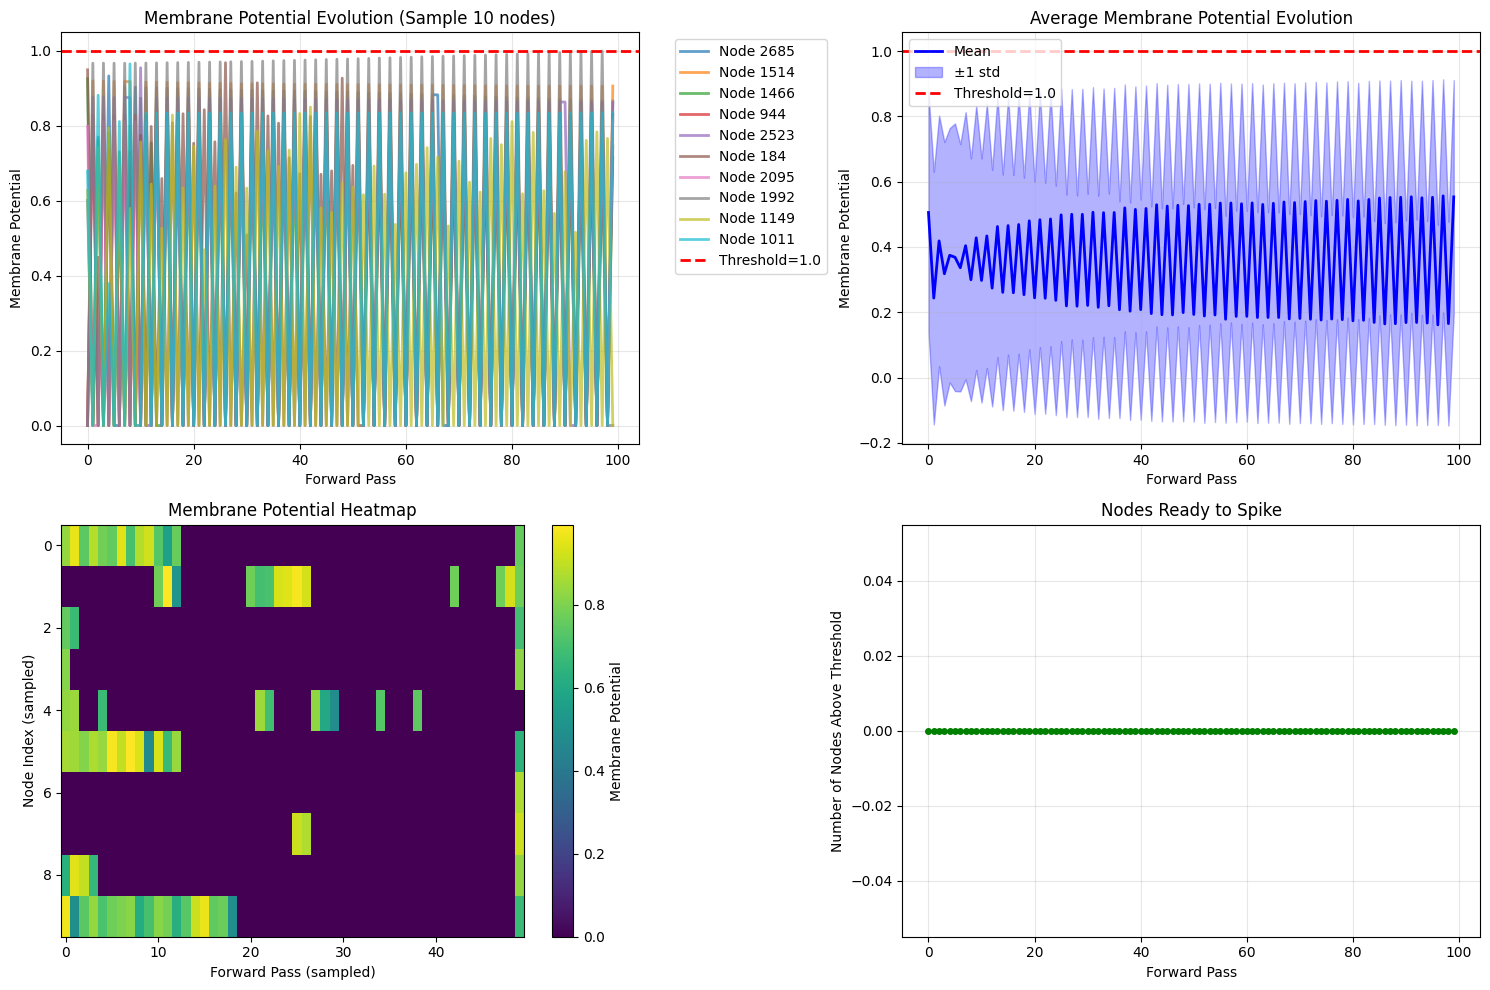

=== Membrane Potential Evolution Statistics ===
Time steps recorded: 100
Total nodes: 2708
Threshold: 1.0
Final average membrane potential: 0.553
Max membrane potential reached: 1.000
Average nodes above threshold: 0.0
--------------------------------------------------

OUTPUT Layer Membrane Potential Evolution:


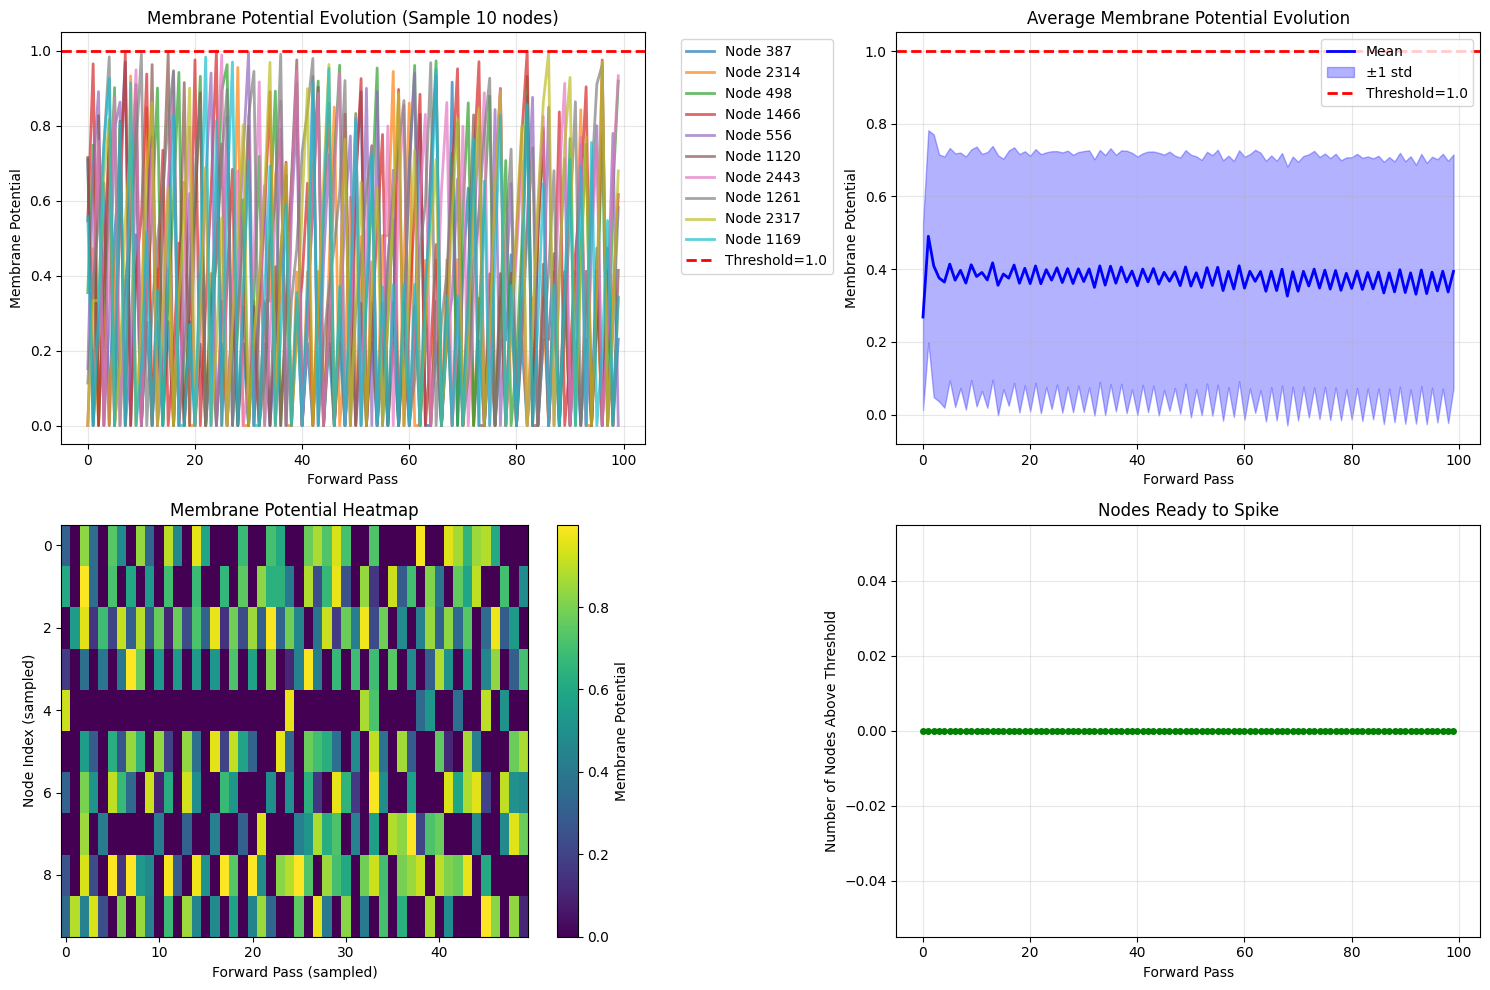

=== Membrane Potential Evolution Statistics ===
Time steps recorded: 100
Total nodes: 2708
Threshold: 1.0
Final average membrane potential: 0.394
Max membrane potential reached: 1.000
Average nodes above threshold: 0.0
--------------------------------------------------

=== Spike Rate Evolution ===


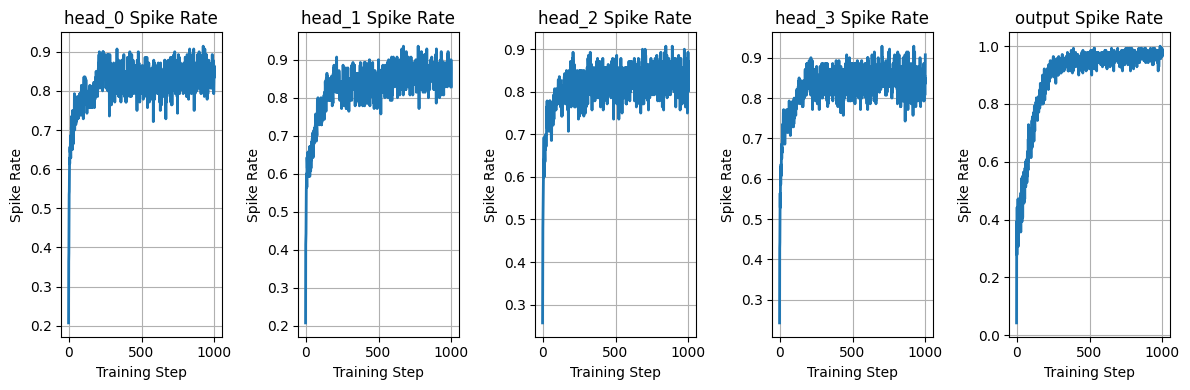


=== Layer-wise Spike Rate Comparison ===


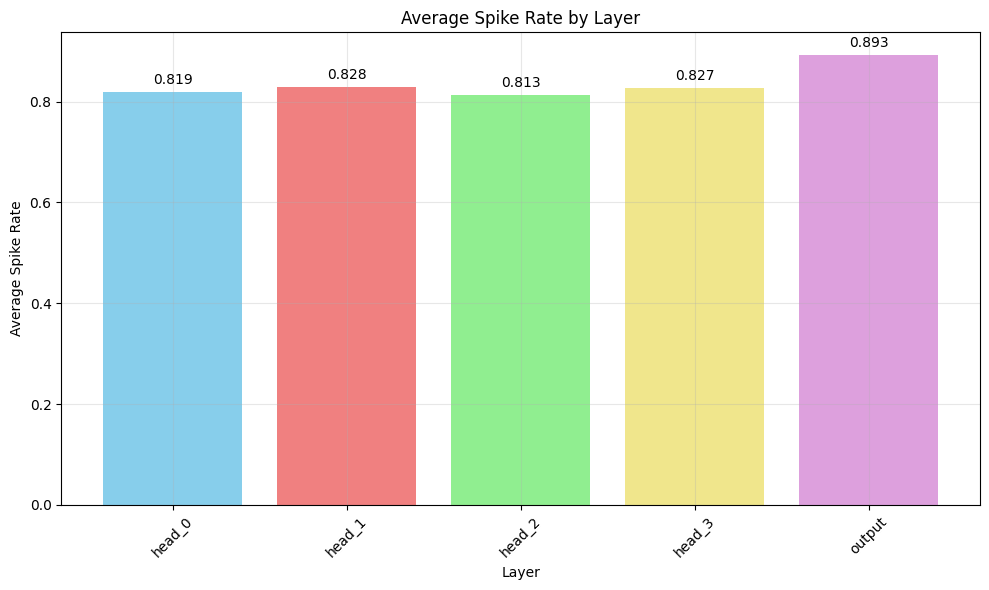


=== Summary ===
Overall average spike rate: 0.836


In [135]:
# スパイク統計の詳細可視化
spike_stats = model.get_all_spike_statistics()

print("=== Detailed Spike Analysis ===")
for layer_name, stats in spike_stats.items():
    if stats['spike_rates']:
        print(f"\n{layer_name.upper()} Layer Analysis:")

        # 基本統計
        spike_rates = stats['spike_rates']
        norms = stats['norms']
        threshold = stats['threshold']

        print(f"- Average spike rate: {np.mean(spike_rates):.3f}")
        print(f"- Spike rate std: {np.std(spike_rates):.3f}")
        print(f"- Threshold: {threshold:.3f}")
        print(f"- Norm mean: {np.mean(norms):.3f}")
        print(f"- Norm std: {np.std(norms):.3f}")

        # 発火ノード統計
        firing_nodes = np.sum(norms >= threshold)
        total_nodes = len(norms)
        print(f"- Firing nodes: {firing_nodes}/{total_nodes} ({firing_nodes/total_nodes*100:.1f}%)")

        # 安全な可視化（エラーを回避）
        try:
            visualize_spike_statistics(spike_rates, norms, threshold)
        except Exception as e:
            print(f"Visualization error for {layer_name}: {e}")
            # 代替の簡単な可視化
            plt.figure(figsize=(12, 4))

            # スパイク率の推移
            plt.subplot(1, 3, 1)
            plt.plot(spike_rates, 'b-o', markersize=4)
            plt.title(f'{layer_name} Spike Rate Evolution')
            plt.xlabel('Training Step')
            plt.ylabel('Spike Rate')
            plt.grid(True, alpha=0.3)

            # ノルム分布
            plt.subplot(1, 3, 2)
            plt.hist(norms, bins=30, alpha=0.7, color='green', edgecolor='black')
            plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2)
            plt.title(f'{layer_name} Output Norm Distribution')
            plt.xlabel('Output Norm')
            plt.ylabel('Count')
            plt.grid(True, alpha=0.3)

            # 発火率
            plt.subplot(1, 3, 3)
            firing_rate = firing_nodes / total_nodes
            silent_rate = 1 - firing_rate
            plt.bar(['Firing', 'Silent'], [firing_rate, silent_rate],
                   color=['lightcoral', 'lightblue'])
            plt.title(f'{layer_name} Node Activity')
            plt.ylabel('Proportion')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

# 膜電位の蓄積過程を可視化
print("\n=== Membrane Potential Evolution Analysis ===")
for layer_name, stats in spike_stats.items():
    if hasattr(model.attentions[0] if 'head_' in layer_name else model.out_att, 'membrane_history'):
        layer_obj = model.attentions[int(layer_name.split('_')[1])] if 'head_' in layer_name else model.out_att
        if layer_obj.membrane_history:
            print(f"\n{layer_name.upper()} Layer Membrane Potential Evolution:")
            visualize_membrane_potential_evolution(
                layer_obj.membrane_history,
                layer_obj.spike_threshold,
                sample_nodes=10
            )
        else:
            print(f"{layer_name}: No membrane potential history recorded.")

# スパイク率の経時変化を表示
print("\n=== Spike Rate Evolution ===")
plt.figure(figsize=(12, 4))

for i, (layer_name, stats) in enumerate(spike_stats.items()):
    if stats['spike_rates']:
        plt.subplot(1, len(spike_stats), i+1)
        plt.plot(stats['spike_rates'], linewidth=2)
        plt.title(f'{layer_name} Spike Rate')
        plt.xlabel('Training Step')
        plt.ylabel('Spike Rate')
        plt.grid(True)

plt.tight_layout()
plt.show()

# 層ごとのスパイク率比較
print("\n=== Layer-wise Spike Rate Comparison ===")
layer_names = []
avg_spike_rates = []

for layer_name, stats in spike_stats.items():
    if stats['spike_rates']:
        layer_names.append(layer_name)
        avg_spike_rates.append(np.mean(stats['spike_rates']))

plt.figure(figsize=(10, 6))
bars = plt.bar(layer_names, avg_spike_rates, color=['skyblue', 'lightcoral', 'lightgreen', 'khaki', 'plum'])
plt.title('Average Spike Rate by Layer')
plt.ylabel('Average Spike Rate')
plt.xlabel('Layer')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 値をバーの上に表示
for bar, rate in zip(bars, avg_spike_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n=== Summary ===")
print(f"Overall average spike rate: {model.get_average_spike_rate():.3f}")
